##### intensity analysis based on gc mask

In [1]:
# import some basic functions
import os
import numpy as np
import re
from skimage import io
import math
import pandas as pd

from typing import Dict, List, Any

from scipy.ndimage import gaussian_filter
from skimage import filters
from skimage.measure import regionprops, label, find_contours
from skimage.morphology import disk,ball,binary_dilation,binary_closing,binary_opening, remove_small_holes
import matplotlib.pyplot as plt

# import self_defined functions
from Import_Functions import import_imgs
import seg_util as su
import measure_util as mu

# function for writing images
import imageio

In [2]:
master_img_folder = r"directory to the test image folder"

##### coefficient of variation

In [ ]:
group_list = []

for item in os.listdir(master_img_folder):
    experiment_set_dir = os.path.join(master_img_folder,item)

    if os.path.isdir(experiment_set_dir):
        cells = os.listdir(experiment_set_dir)
        for cell in cells:
            cell_dir = os.path.join(experiment_set_dir,cell)
            cell_id = os.path.basename(experiment_set_dir) + "\\" + cell

            # read the images
            gc_mask = import_imgs(cell_dir, image_name="hole_filled.tif", is_mask=True)
            raw_img = import_imgs(cell_dir, image_name="Composite_stack.tif")

            # measure cv and generate dataframe
            cv_df = mu.coefficient_of_variances(gc_mask, raw_img, cell_id=cell_id,measured_parameters = ["cell_id", "cv_r", "cv_g", "cv_b", "qcd_r", "qcd_g", "qcd_b"])

            # add larval stage to each cell
            cv_df["stage"] = cell_id[cell_id.find("L"):cell_id.find("L")+2]
            group_list.append(cv_df)
    

In [ ]:
cv_grouped_df = mu.group_sort_larval_df(group_list)
cv_grouped_df[cv_grouped_df.columns[1:-1]] = cv_grouped_df[cv_grouped_df.columns[1:-1]].astype(float)

In [ ]:
# get each larval stage dataframe save as dictionary
L1 = grouped_df[grouped_df["stage"] == "L1"]
L2 = grouped_df[grouped_df["stage"] == "L2"]
L3 = grouped_df[grouped_df["stage"] == "L3"]
L4 = grouped_df[grouped_df["stage"] == "L4"]
df_dict = {"L1": L1, "L2": L2, "L3": L3, "L4": L4}

In [ ]:
red_df = cv_grouped_df[["cell_id","cv_r","qcd_r","stage"]]
green_df = cv_grouped_df[["cell_id","cv_g","qcd_g","stage"]]
blue_df = cv_grouped_df[["cell_id","cv_b","qcd_b","stage"]]
cv_plot_red = mu.box_plot(red_df, measurement_to_plot="cv_r", y_axis_label="Coefficient of Variation", add_title="DAO-5 CV")
cv_plot_green = mu.box_plot(green_df, measurement_to_plot="cv_g", y_axis_label="Coefficient of Variation", add_title="RPOA-2 CV")
cv_plot_blue = mu.box_plot(blue_df, measurement_to_plot="cv_b", y_axis_label="Coefficient of Variation", add_title="LPD-7 CV")

##### how GC size grow, C_dilute, C_dense

###### run with one image

In [ ]:
# read image by import_img function or read image directly
folder_raw = r"directory to the folder containing example image"
cell_id = r"20220712_L2\7_1"

raw_img = import_imgs(folder_raw, "Composite_stack.tif")
nucleus = import_imgs(folder_raw, "nucleus_slice.tif",is_mask=True)
background = import_imgs(folder_raw, "background_mask.tif",is_mask=True)


gc_mask = import_imgs(folder_raw, "gc.tif",is_mask=True)
gc_mask_hole_filled = import_imgs(folder_raw, "hole_filled.tif",is_mask=True)


In [ ]:
# subtract background
sub_img = su.bg_subtraction(raw_img, background)

In [ ]:
# get the largest gc_mask_hole_filled slice
z_slice = mu.get_largetest_slice(gc_mask_hole_filled)

In [ ]:
# get the largest slice of each image
gc_img = sub_img[z_slice,:,:,2]
nucleus_slice = nucleus[z_slice,...]
background_slice = background[z_slice,...]
gc_slice = gc_mask[z_slice,...]
gc_hole_filled_slice = gc_mask_hole_filled[z_slice,...]
# get nucleoplasm region
nucleoplasm = nucleus_slice - gc_hole_filled_slice

In [ ]:
# find contours of green mask and nucleus
contour_nucleus = find_contours(nucleus_slice, 0.5)
contour_gc = find_contours(gc_hole_filled_slice, 0.5)
contour_bg = find_contours(background_slice, 0.5)

fig, axs = plt.subplots(1,1, figsize=(8,8), dpi=72)
axs.imshow(gc_img, cmap="gray")
for contour in contour_gc:
    axs.plot(contour[:, 1], contour[:, 0], 'r--')
for contour in contour_nucleus:
    axs.plot(contour[:, 1], contour[:, 0], 'b--')
for contour in contour_bg:
    axs.plot(contour[:, 1], contour[:, 0], 'g--')

In [ ]:
df = mu.concentration_gc(
    raw_img = raw_img[z_slice,:,:,2],
    raw_bg_subt = gc_img,
    background_mask = background_slice,
    nucleoplasm_mask = nucleoplasm,
    seg_mask = gc_slice,
    seg_hole_filled_mask = gc_hole_filled_slice,
    nucleus_mask = nucleus_slice, 
    cell_id=cell_id,measured_parameters = ["cell_id", "C_bg", "C_dilute", "C_dense", "C_total", "pc"])

###### batch process: Csat

In [ ]:
# group process
raw_main_folder = r"directory to the test image folder"

group_list = []

for item in os.listdir(raw_main_folder):
    experiment_set_dir = os.path.join(raw_main_folder,item)

    if os.path.isdir(experiment_set_dir):
        cells = os.listdir(experiment_set_dir)
        for cell in cells:
            cell_dir = os.path.join(experiment_set_dir,cell)
            cell_id = os.path.basename(experiment_set_dir) + "\\" + cell

            # read the images
            raw_img = import_imgs(cell_dir, "Composite_stack.tif")
            nucleus = import_imgs(cell_dir, "nucleus_slice.tif",is_mask=True)
            background = import_imgs(cell_dir, "background_mask.tif",is_mask=True)
            gc_mask = import_imgs(cell_dir, "gc.tif",is_mask=True)
            gc_mask_hole_filled = import_imgs(cell_dir, "hole_filled.tif",is_mask=True)
            
            # subtract background
            sub_img = su.bg_subtraction(raw_img, background)

            # get the largest gc_mask_hole_filled slice
            z_slice = mu.get_largetest_slice(gc_mask_hole_filled)

            # get the largest slice of each image
            gc_img = sub_img[z_slice,:,:,2]
            nucleus_slice = nucleus[z_slice,...]
            background_slice = background[z_slice,...]
            gc_slice = gc_mask[z_slice,...]
            gc_hole_filled_slice = gc_mask_hole_filled[z_slice,...]

            # get nucleoplasm region
            nucleoplasm = nucleus_slice - gc_hole_filled_slice

            
            # measure
            df = mu.concentration_gc(
                raw_img = raw_img[z_slice,:,:,2],
                raw_bg_subt = gc_img,
                background_mask = background_slice,
                nucleoplasm_mask = nucleoplasm,
                seg_mask = gc_slice,
                seg_hole_filled_mask = gc_hole_filled_slice,
                nucleus_mask = nucleus_slice, 
                cell_id=cell_id,measured_parameters = ["cell_id", "C_bg", "C_dilute", "C_dense", "C_total","pc"])
            group_list.append(df)

# # create total dataframe
C_grouped_df = mu.group_sort_larval_df(group_list)


In [ ]:
C_dense = mu.box_plot(C_grouped_df, measurement_to_plot = "C_dense",y_axis_label="C_dense")
C_dilute = mu.box_plot(C_grouped_df, measurement_to_plot = "C_dilute",y_axis_label="C_dilute")
C_total = mu.box_plot(C_grouped_df, measurement_to_plot = "C_total",y_axis_label="C_total")
pc = mu.box_plot(C_grouped_df, measurement_to_plot = "pc",y_axis_label="pc")

In [ ]:
# plot C_total value
L1 = C_grouped_df.loc[C_grouped_df["stage"] == "L1", ["C_total", "C_dilute"]]
L2 = C_grouped_df.loc[C_grouped_df["stage"] == "L2", ["C_total", "C_dilute"]]
L3 = C_grouped_df.loc[C_grouped_df["stage"] == "L3", ["C_total", "C_dilute"]]
L4 = C_grouped_df.loc[C_grouped_df["stage"] == "L4", ["C_total", "C_dilute"]]

fig, axs = plt.subplots(1,1, figsize=(8,8))
# mean for each stage
dilute_mean_L1 = round(L1["C_dilute"].mean())
dilute_mean_L2 = round(L2["C_dilute"].mean())
dilute_mean_L3 = round(L3["C_dilute"].mean())
dilute_mean_L4 = round(L4["C_dilute"].mean())

# mean for each stage
dense_mean_L1 = round(L1["C_total"].mean())
dense_mean_L2 = round(L2["C_total"].mean())
dense_mean_L3 = round(L3["C_total"].mean())
dense_mean_L4 = round(L4["C_total"].mean())

# connect dilute and dense spot for each larval stage
axs.plot([dilute_mean_L1,dense_mean_L1],[1,1], linestyle = "--", color = "r", label = "tie line at L1")
axs.plot([dilute_mean_L2,dense_mean_L2],[2,2], linestyle = "--", color = "g", label = "tie line at L2")
axs.plot([dilute_mean_L3,dense_mean_L3],[3,3], linestyle = "--", color = "b", label = "tie line at L3")
axs.plot([dilute_mean_L4,dense_mean_L4],[4,4], linestyle = "--", color = "k", label = "tie line at L4")

# connect all dilute and dense spot
x_values_dilute = [dilute_mean_L1, dilute_mean_L2, dilute_mean_L3, dilute_mean_L4]
x_values_dense = [dense_mean_L1, dense_mean_L2, dense_mean_L3, dense_mean_L4]
y_values = [1,2,3,4]
axs.plot(x_values_dilute, y_values, linestyle = "-",color = "blue", label = "dilute")
axs.plot(x_values_dense, y_values, linestyle = "-",color = "red", label = "dense")
axs.set_xlim(0, max(x_values_dense))
plt.legend()

In [ ]:
def forceAspect(ax,ratio):
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

In [ ]:
# plot C_total value
L1 = C_grouped_df.loc[C_grouped_df["stage"] == "L1", ["C_total", "C_dilute"]]
L2 = C_grouped_df.loc[C_grouped_df["stage"] == "L2", ["C_total", "C_dilute"]]
L3 = C_grouped_df.loc[C_grouped_df["stage"] == "L3", ["C_total", "C_dilute"]]
L4 = C_grouped_df.loc[C_grouped_df["stage"] == "L4", ["C_total", "C_dilute"]]

fig, axs = plt.subplots(1,1, figsize=(4,4))

axs.scatter(L1["C_total"], L1["C_dilute"], color = "r", label="L1")
axs.scatter(L2["C_total"], L2["C_dilute"], color = "g", label="L2")
axs.scatter(L3["C_total"], L3["C_dilute"], color = "b", label="L3")
axs.scatter(L4["C_total"], L4["C_dilute"], color = "k", label="L4")

from sklearn import linear_model
import scipy as sp
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
# fit linear regression model
x_L1 = L1[["C_total"]]
y_L1 = L1[["C_dilute"]]
model = linear_model.LinearRegression().fit(x_L1, y_L1)
coef = model.coef_
y_pred = model.predict(x_L1)
coor, p = sp.stats.pearsonr(x_L1.C_total, y_L1.C_dilute)
print(coor)
# plot regression line
axs.plot(x_L1.C_total, y_pred, color="black", label="person_coorelation r={:.3f}".format(p))
axs.set_xlabel("C_total")
axs.set_ylabel("C_dilute")
forceAspect(axs,1)
plt.legend()

In [ ]:
# extracting number of objects in each larval stages
stages = C_grouped_df.stage.dropna().unique()
L1 = C_grouped_df.loc[C_grouped_df["stage"]=="L1","C_dilute"]
L2 = C_grouped_df.loc[C_grouped_df["stage"]=="L2","C_dilute"]
L3 = C_grouped_df.loc[C_grouped_df["stage"]=="L3","C_dilute"]
L4 = C_grouped_df.loc[C_grouped_df["stage"]=="L4","C_dilute"]
vals = [L1,L2,L3,L4]

# create a box plot
fig, ax =plt.subplots(ncols=1,nrows=1,figsize=(4,4))
ax.boxplot(vals,notch=None,whis=(5,95),showmeans=True, showfliers=False,
            meanprops={"marker":"^","markersize":10,"markerfacecolor":"white", "markeredgecolor":"b"},
            medianprops={"linestyle":'-', "color":'red', "linewidth":2})
# Add legend
mean_marker = plt.Line2D([0], [0], marker='^', color='b', markersize=10, label='Mean')
median_line = plt.Line2D([0], [0], linestyle='-', color='red', linewidth=2, label='Median')
ax.legend(handles=[mean_marker, median_line], loc='best')

# add labels to the x-axis
ax.set_xticks(range(1, len(vals) + 1), stages)

# add individual data points to the box plot
for i, lst in enumerate(vals):
    # make data points spreaded by normal distribution
    xs = np.random.normal(i + 1, 0.04, lst.shape[0])
    ax.scatter(xs, lst, color="k",alpha=0.5)

# Set labels and title
ax.set_xlabel("Larval stages post synchronization",fontsize=12)
ax.set_ylabel("Intensity (A.U.)",fontsize=12)
ax.set_title("Dilute concentration",fontsize=12)

##### relative colocalization

###### overlap of top x% gray values
- relative number: sort pixel by intensity value, then take the top x%

In [ ]:
# dilate GC mask
dilated_GC = binary_dilation(gc_mask_hole_filled,footprint=ball(5))
dilated_GC[0,...] = 0
dilated_GC[-1,...] = 0
contour_dilated = find_contours(np.max(dilated_GC,axis=0),0.1)

In [ ]:
# merge three channels into one
raw_in_mask = np.stack([np.where(dilated_GC>0,raw_img[...,i],0) for i in range(raw_img.shape[-1])],axis=3)


###### relative number, segment top x% of the smoothed image

In [ ]:
top_2 = mu.relative_number_of_pixels(raw_img, dilated_GC, 0.1)
# plot
fig,axs = plt.subplots(3,3,figsize=(15,10))
for i in range(raw_in_mask.shape[-1]):
    axs[0,i].imshow(raw_in_mask[z_slice,:,:,i],cmap="gray")
    axs[1,i].imshow(top_2[z_slice,:,:,i],cmap="gray")

    for contour in contour_dilated:
        axs[0,i].plot(contour[:,1],contour[:,0],'r--')

    axs[2,i].hist( raw_in_mask[...,i][raw_in_mask[...,i]>0],bins=100)

axs[0,1].set_title("Smoothed image(nucleolar region)")
axs[1,1].set_title("top {} % Pixels".format(0.1*100))
axs[2,1].set_title("Gray value histogram(in nucleolar mask)")
plt.tight_layout()

In [ ]:
df = mu.overlap_3channel(top_img=top_2, cell_id=cell_id)

In [ ]:
# create a heatmap of overlap ratio
channels = ["Red","Green","Blue"]
# store overlap in a 3x3 matrix
overlap = np.zeros((3,3),dtype=float)

# get each channel counts and overlap counts
Red_counts = np.count_nonzero(top_[...,0]>0)
Green_counts = np.count_nonzero(top_[...,1]>0)
Blue_counts = np.count_nonzero(top_[...,2]>0)
# overlap counts
RG_counts = np.count_nonzero(overlap_r_g>0)
RB_counts = np.count_nonzero(overlap_r_b>0)
GB_counts = np.count_nonzero(overlap_g_b>0)

# Red channel overlaps with channels
overlap[0,0] = "{:.2f}".format(Red_counts/Red_counts)
overlap[0,1] = "{:.2f}".format(RG_counts/Red_counts)
overlap[0,2] = "{:.2f}".format(RB_counts/Red_counts)

# Green channel overlaps with channels
overlap[1,0] = "{:.2f}".format(RG_counts/Green_counts)
overlap[1,1] = "{:.2f}".format(Green_counts/Green_counts)
overlap[1,2] = "{:.2f}".format(GB_counts/Green_counts)

# Blue channel overlaps with channels
overlap[2,0] = "{:.2f}".format(RB_counts/Blue_counts)
overlap[2,1] = "{:.2f}".format(GB_counts/Blue_counts)
overlap[2,2] = "{:.2f}".format(Blue_counts/Blue_counts)

# plot heatmap with ratios
fig,axs = plt.subplots(1,1,figsize=(6,6))
im = axs.imshow(overlap,cmap="viridis")
# show ticks and labels with the repective list channels
axs.set_xticks(np.arange(len(channels)),labels=channels,fontsize=15)
axs.set_yticks(np.arange(len(channels)),labels=channels,fontsize=15)

# Loop over data dimensions and create text annotations.
for i in range(len(channels)):
    for j in range(len(channels)):
        text = axs.text(j, i, overlap[i, j],
                       ha="center", va="center", color="red", fontsize=20)
#axs.set_ylabel("Each channel",fontsize=15)
#axs.set_xlabel("Colocalized channels",fontsize=15)
axs.set_title("Ratio of overlapped pixels in each channel(top 60%)",fontsize=15)

###### group process

In [3]:
group_colocal_list = []

for item in os.listdir(master_img_folder):
    experiment_set_dir = os.path.join(master_img_folder,item)

    if os.path.isdir(experiment_set_dir):
        cells = os.listdir(experiment_set_dir)
        for cell in cells:
            cell_dir = os.path.join(experiment_set_dir,cell)
            cell_id = os.path.basename(experiment_set_dir) + "\\" + cell

            # read the images
            raw_img = import_imgs(cell_dir, image_name="Composite_stack.tif")
            gc_mask = import_imgs(cell_dir, image_name="hole_filled.tif", is_mask=True)

            # dilate GC mask
            dilated_GC = binary_dilation(gc_mask,footprint=ball(5))
            dilated_GC[0,...] = 0
            dilated_GC[-1,...] = 0

            # merge three channels into one
            raw_in_mask = np.stack([np.where(dilated_GC>0,raw_img[...,i],0) for i in range(raw_img.shape[-1])],axis=3)

            # measure colocalization and generate dataframe
            top_10 = mu.relative_number_of_pixels(raw_img, dilated_GC, 0.1)
            colocal_df = mu.overlap_3channel(top_img=top_10, cell_id=cell_id)

            group_colocal_list.append(colocal_df)
# create total dataframe
colocal_grouped_df = mu.group_sort_larval_df(group_colocal_list)

In [4]:
# get each larval stage dataframe save as dictionary
L1 = colocal_grouped_df[colocal_grouped_df["stage"] == "L1"]
L2 = colocal_grouped_df[colocal_grouped_df["stage"] == "L2"]
L3 = colocal_grouped_df[colocal_grouped_df["stage"] == "L3"]
L4 = colocal_grouped_df[colocal_grouped_df["stage"] == "L4"]
df_dict = {"L1": L1, "L2": L2, "L3": L3, "L4": L4}

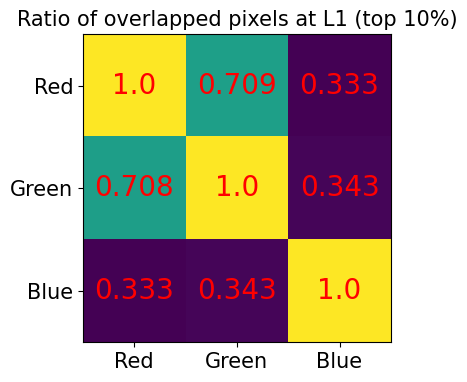

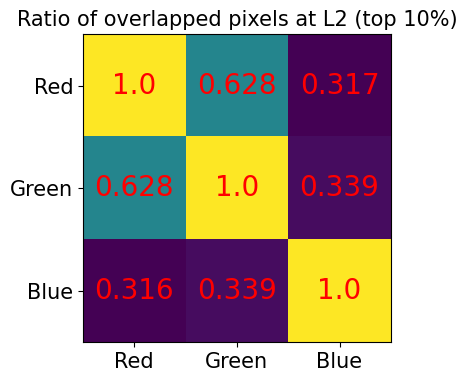

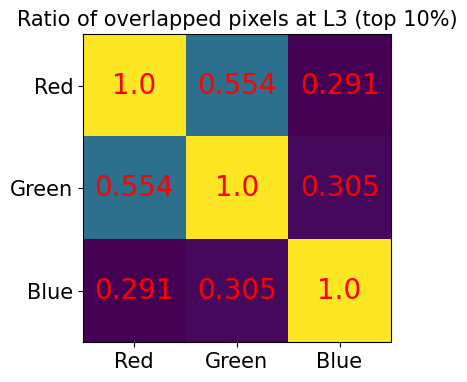

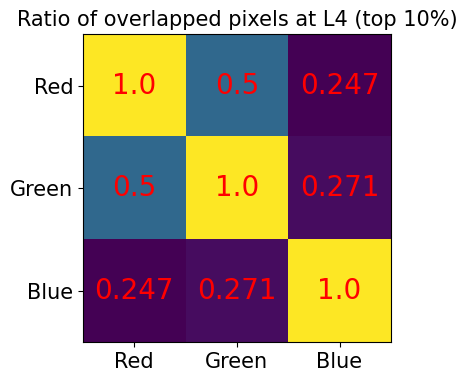

In [5]:
# calculate mean for each column in each stage
for key in df_dict.keys():
    df = df_dict[key]
    temp_df = df[df.columns[1:-1]].astype(float)
    mean_df = pd.DataFrame(columns=temp_df.columns)
    mean_df.loc[0,mean_df.columns] = pd.Series(temp_df.mean(axis=0))
    mu.overlap_heatmap(mean_df, stage=key)
